## Analisis Cancer

Miguel Gutierrez

El presente trabajo tratamos de replicar el articulo en la obtencion de descriptores, luego finalmente unimos todos los descriptores para encontrar el mejor modelo.

In [1]:
import os
import numpy as np
import seaborn as sns
import os
import skimage.exposure as exposure
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from skimage import io
from os.path import join
from skimage import transform ,feature, measure,img_as_ubyte,data
from skimage.color import label2rgb, rgb2gray
from skimage.measure import regionprops, regionprops_table,moments_central,label, find_contours, moments_normalized, moments_hu
from scipy.spatial import distance_matrix
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis, entropy
from skimage.transform import rotate
from skimage.feature import local_binary_pattern,ORB,hog,greycomatrix
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi


## Importamos las Imagenes

Primero cargamos las imagenes, solo vamos a trabajar con las de validación.

In [2]:
imgs = []
DIR = 'colorectal_cancer/validation'
files = os.listdir(DIR)
print(files,'\n')
Lista = ['Tumor','Stroma','Complex','Lympho','Debris','Mucosa','Adipose','Empty']
Tumor =[]
Stroma = []
Complex = []
Lympho = []
Debris = []
Mucosa = []
Adipose = []
Empty = []
# Iterando Sobre SubCarpeta
for i in range(len(files)):
    files1 = os.listdir(join(DIR, files[i]))
    if i==0:
        for j in range(len(files1)):
            Tumor.append(io.imread(join(DIR, files[i],files1[j])))
    if i==1:
        for j in range(len(files1)):
            Stroma.append(io.imread(join(DIR, files[i],files1[j])))
    if i==2:
        for j in range(len(files1)):
            Complex.append(io.imread(join(DIR, files[i],files1[j])))
    if i==3:
        for j in range(len(files1)):
            Lympho.append(io.imread(join(DIR, files[i],files1[j])))
    if i==4:
        for j in range(len(files1)):
            Debris.append(io.imread(join(DIR, files[i],files1[j])))
    if i==5:
        for j in range(len(files1)):
            Mucosa.append(io.imread(join(DIR, files[i],files1[j])))
    if i==6:
        for j in range(len(files1)):
            Adipose.append(io.imread(join(DIR, files[i],files1[j])))
    if i==7:
        for j in range(len(files1)):
            Empty.append(io.imread(join(DIR, files[i],files1[j])))
            
            
# Pasando imagenes a grises
Tumor = [rgb2gray(im) for im in Tumor]
Stroma = [rgb2gray(im) for im in Stroma]
Complex = [rgb2gray(im) for im in Complex]
Lympho = [rgb2gray(im) for im in Lympho]
Debris = [rgb2gray(im) for im in Debris]
Mucosa = [rgb2gray(im) for im in Mucosa]
Adipose = [rgb2gray(im) for im in Adipose]
Empty = [rgb2gray(im) for im in Empty]

Todo = [Tumor,Stroma,Complex,Lympho,Debris,Mucosa,Adipose,Empty]

['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY'] 



Verificamos que cargo correctamente las imagenes

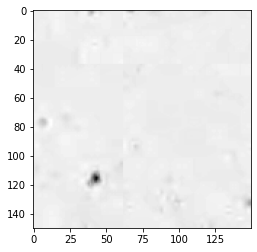

In [3]:
plt.imshow(Empty[0],cmap='gray')

# Low Histogram

Los estadisticos bajos que utilice fueron la media,variance, skewnes,curtosis,minimo,maximo,contraste 

In [4]:
def low_histogram(class1):
    # Class1: Imagen
    # Descriptores : Lista estadisticos bajos
    descriptores = []
    for img in class1:
        # Obtencion de estadisticos
        aux = [img.mean(), img.std(), skew(img.ravel()),
               kurtosis(img.ravel()), img.min(), img.max(),
               1.0 - (1.0/(1+ img.std()**2))]
        descriptores.append(aux)
    return descriptores

Aplicamos el low histogram en todas las imagenes

In [5]:
df_t_l = pd.DataFrame(columns=["media","desviacion estándar", "skewness",
                                              "curtosis","minimo", "maximo","contraste","clase"])
for i in range(0,len(Todo)):
    des= low_histogram(Todo[i])
    df = pd.DataFrame(des, columns=["media","desviacion estándar", "skewness",
                                              "curtosis","minimo", "maximo","contraste"])
    df['clase']=Lista[i]
    df_t_l = pd.concat([df_t_l,df], ignore_index=True)
    print(f"La clase {Lista[i]} analizada")

La clase Tumor analizada
La clase Stroma analizada
La clase Complex analizada
La clase Lympho analizada
La clase Debris analizada
La clase Mucosa analizada
La clase Adipose analizada
La clase Empty analizada


In [6]:
df_t_l

,media,desviacion estándar,skewness,curtosis,minimo,maximo,contraste,clase
0,0.342303,0.302688,1.038178,-0.597964,0.035210,0.950916,0.083930,Tumor
1,0.284395,0.132290,1.533068,3.513061,0.037509,0.933012,0.017200,Tumor
2,0.300449,0.220826,1.110602,0.225319,0.021488,0.917824,0.046497,Tumor
3,0.344726,0.197159,1.586735,1.801484,0.067795,0.969140,0.037417,Tumor
4,0.426256,0.257157,0.493997,-1.126756,0.030187,0.939517,0.062028,Tumor
...,...,...,...,...,...,...,...,...
974,0.953664,0.011838,-14.605011,297.483326,0.586165,0.989910,0.000140,Empty
975,0.953490,0.012690,-11.839159,195.084762,0.663456,0.982364,0.000161,Empty
976,0.954638,0.004596,-3.201485,48.847362,0.843703,0.979827,0.000021,Empty
977,0.954122,0.019744,-13.293419,210.103112,0.511363,0.985720,0.000390,Empty


## High Histogram

Probamos que funciona con una imagen

[2.40403777e+25 1.49531130e+26 9.20146854e+28 3.18396786e+30
 4.76579301e+32 2.85179354e+34 2.98461384e+36 2.23140872e+38
 2.07098370e+40]


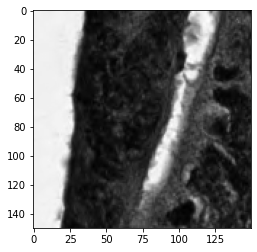

In [7]:
central = moments_central(Tumor[0],order=11)
central = central[:,2:11]
central = np.mean(central,axis=0)
plt.imshow(Tumor[0],cmap='gray')
print(central)

El histograma retorna la media de los momentos centrales

In [8]:
def high_histogram(class1):
    # Class 1 Imagen
    # Descriptores
    central = moments_central(class1,order=11)
    central = central[:,2:12]
    central = np.mean(central,axis=0)
    return central

Creamos la base de datos

In [9]:
df_t_h = pd.DataFrame(columns=[str(x)+' Momento' for x in range(2,12)])
for i in range(0,len(Todo)):
    clase = Todo[i]
    print(f"La clase {Lista[i]} analizada")
    for img in clase:
        central = high_histogram(img)
        df = pd.DataFrame([central], columns=[str(x)+' Momento' for x in range(2,12)])
        df['clase']=Lista[i]
        df_t_h = pd.concat([df_t_h,df], ignore_index=True)

La clase Tumor analizada
La clase Stroma analizada
La clase Complex analizada
La clase Lympho analizada
La clase Debris analizada
La clase Mucosa analizada
La clase Adipose analizada
La clase Empty analizada


In [10]:
df_t_h

,2 Momento,3 Momento,4 Momento,5 Momento,6 Momento,7 Momento,8 Momento,9 Momento,10 Momento,11 Momento,clase
0,2.404038e+25,1.495311e+26,9.201469e+28,3.183968e+30,4.765793e+32,2.851794e+34,2.984614e+36,2.231409e+38,2.070984e+40,1.698009e+42,Tumor
1,1.024494e+25,6.213925e+26,3.657138e+28,2.389448e+30,1.628867e+32,1.105846e+34,8.002568e+35,5.568161e+37,4.125002e+39,2.923090e+41,Tumor
2,-4.567811e+25,-8.027656e+25,-1.700597e+29,-1.498905e+30,-7.236907e+32,-1.142376e+34,-3.317133e+36,-7.371632e+37,-1.594170e+40,-4.468822e+41,Tumor
3,-3.113272e+25,-8.454881e+26,-1.217710e+29,-4.431659e+30,-5.575508e+32,-2.502299e+34,-2.801839e+36,-1.479809e+38,-1.503980e+40,-8.974465e+41,Tumor
4,3.131477e+25,-1.355277e+26,1.057623e+29,4.158094e+29,4.332257e+32,7.220768e+33,2.015840e+36,6.186984e+37,1.030140e+40,4.497641e+41,Tumor
...,...,...,...,...,...,...,...,...,...,...,...
974,1.864395e+24,4.648701e+24,6.311105e+27,2.002565e+28,2.539999e+31,9.511471e+31,1.110900e+35,4.719931e+35,5.104471e+38,2.402237e+39,Empty
975,2.322414e+24,3.104447e+24,8.046245e+27,2.092607e+28,3.307442e+31,1.171650e+32,1.471603e+35,6.188783e+35,6.851918e+38,3.202940e+39,Empty
976,1.608005e+24,-3.149427e+24,5.456131e+27,-1.139403e+28,2.208910e+31,-4.475492e+31,9.733105e+34,-1.855352e+35,4.507047e+38,-8.018024e+38,Empty
977,3.383597e+24,2.039174e+24,1.168574e+28,1.143907e+28,4.772406e+31,6.001953e+31,2.114610e+35,3.106298e+35,9.831334e+38,1.595383e+39,Empty


## Local Binary Patterns (LBP)

LBP mira los puntos alrededor del punto central y testear si lo puntos de alredero son mayores o menores que el punto central ,es decir es un resultado binario. Uno puede decidir el tamaño del radio y el numero de puntos a considerar alrededor. En el artículo hacen algo similar pero con una transformada de fourier invariante (Un poco mas complicada). Como consecuencia solo reducimos el numero de bins a 38. Estos serían nuestros descriptores. Se hizo con un radio de tamaño 1 y con 8 vecinos.

## Ejemplo Imagen

In [11]:
def hist(lbp1):
    n_bins = int(lbp1.max() + 1)
    freq1 = plt.hist(lbp1.ravel(), bins=38, range=(0, 38),
                   facecolor='0.5')

    return freq1


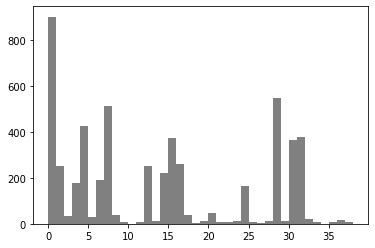

In [12]:
radius = 1
n_points = 8 * radius

lbp = local_binary_pattern(Tumor[0], n_points, radius)

freq1 =hist(lbp)

In [13]:
def LBP(Image):
    radius = 1
    n_points = 8 * radius

    lbp = local_binary_pattern(Tumor[0], n_points, radius)

    freq1 = hist(lbp)
    return freq1[0]

La clase Tumor analizada
La clase Stroma analizada
La clase Complex analizada
La clase Lympho analizada
La clase Debris analizada
La clase Mucosa analizada
La clase Adipose analizada
La clase Empty analizada


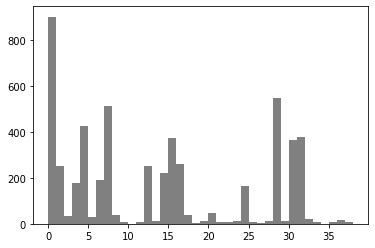

In [14]:
df_t_lp = pd.DataFrame(columns=['Bin'+str(x) for x in range(0,38)])
for i in range(0,len(Todo)):
    clase = Todo[i]
    print(f"La clase {Lista[i]} analizada")
    for img in clase:
        lpi = LBP(img)
        df = pd.DataFrame([lpi], columns=['Bin'+str(x) for x in range(0,38)])
        df['clase']=Lista[i]
        df_t_lp = pd.concat([df_t_lp,df], ignore_index=True)

In [15]:
df_t_lp

,Bin0,Bin1,Bin2,Bin3,Bin4,Bin5,Bin6,Bin7,Bin8,Bin9,...,Bin29,Bin30,Bin31,Bin32,Bin33,Bin34,Bin35,Bin36,Bin37,clase
0,903.0,254.0,32.0,180.0,426.0,31.0,193.0,514.0,38.0,6.0,...,14.0,365.0,378.0,22.0,9.0,0.0,9.0,17.0,8.0,Tumor
1,903.0,254.0,32.0,180.0,426.0,31.0,193.0,514.0,38.0,6.0,...,14.0,365.0,378.0,22.0,9.0,0.0,9.0,17.0,8.0,Tumor
2,903.0,254.0,32.0,180.0,426.0,31.0,193.0,514.0,38.0,6.0,...,14.0,365.0,378.0,22.0,9.0,0.0,9.0,17.0,8.0,Tumor
3,903.0,254.0,32.0,180.0,426.0,31.0,193.0,514.0,38.0,6.0,...,14.0,365.0,378.0,22.0,9.0,0.0,9.0,17.0,8.0,Tumor
4,903.0,254.0,32.0,180.0,426.0,31.0,193.0,514.0,38.0,6.0,...,14.0,365.0,378.0,22.0,9.0,0.0,9.0,17.0,8.0,Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,903.0,254.0,32.0,180.0,426.0,31.0,193.0,514.0,38.0,6.0,...,14.0,365.0,378.0,22.0,9.0,0.0,9.0,17.0,8.0,Empty
975,903.0,254.0,32.0,180.0,426.0,31.0,193.0,514.0,38.0,6.0,...,14.0,365.0,378.0,22.0,9.0,0.0,9.0,17.0,8.0,Empty
976,903.0,254.0,32.0,180.0,426.0,31.0,193.0,514.0,38.0,6.0,...,14.0,365.0,378.0,22.0,9.0,0.0,9.0,17.0,8.0,Empty
977,903.0,254.0,32.0,180.0,426.0,31.0,193.0,514.0,38.0,6.0,...,14.0,365.0,378.0,22.0,9.0,0.0,9.0,17.0,8.0,Empty


# GCLM

Se utilizaron las cuatro direcciones 0,45,90 y 135, y cinco vectores de desplazamiento de 1 a 5px. Luego se hace el promedio por rotacion para hacerlo invariante a rotaciones. Se obtuvieron los estadisticos de contraste, correlationc, energia, homogeneidad, obteniendo 20 descriptores por cada imagen.

In [16]:
w=10
h=10
fig=plt.figure(figsize=(15, 15))
columns = 2
rows = 5
angulos = [0,45,90,135]
final = []



def gclm(img):
    df1 = pd.DataFrame()
    for d in range(1,6):
        
        contraste = []
        disimilaridad = []
        homogeneidad = []
        ASMl = []
        energia = []
        correlacion = []
        matriz_angulos = []
        
        for j in angulos:
            m_angulos = feature.greycomatrix(img_as_ubyte(img),angles = [j],distances=[d],symmetric=True)
            matriz_angulos.append(m_angulos)

        # Contraste
        contrast_propiedad = []
        dissimilarity_propiedad = []
        homogeneity_propiedad = []
        ASM_propiedad = []
        energy_propiedad = []
        correlation_propiedad = []

        for k in range(0,4):

            contrast= feature.greycoprops(matriz_angulos[k],'contrast')
            dissimilarity= feature.greycoprops(matriz_angulos[k],'dissimilarity')
            homogeneity= feature.greycoprops(matriz_angulos[k],'homogeneity')
            ASM = feature.greycoprops(matriz_angulos[k],'ASM')
            energy= feature.greycoprops(matriz_angulos[k],'energy')
            correlation= feature.greycoprops(matriz_angulos[k],'correlation')

            contrast_propiedad.append(contrast)
            dissimilarity_propiedad.append(dissimilarity)
            homogeneity_propiedad.append(homogeneity)
            ASM_propiedad.append(ASM)
            energy_propiedad.append(energy)
            correlation_propiedad.append(correlation)

        contraste.append(np.mean(contrast_propiedad))
        disimilaridad.append(np.mean(dissimilarity_propiedad))
        homogeneidad.append(np.mean(homogeneity_propiedad))
        ASMl.append(np.mean(ASM_propiedad))
        energia.append(np.mean(energy_propiedad))
        correlacion.append(np.mean(correlation_propiedad))

        if d == 1:
            df1 = pd.DataFrame({f'contrast {d}':contraste,f'dissimilarity {d}':disimilaridad,f'homogeneity {d}':homogeneidad,f'ASM {d}':ASMl,f'energy {d}':energia,f'correlation {d}':correlacion})
        else:
            df2 = pd.DataFrame({f'contrast {d}':contraste,f'dissimilarity {d}':disimilaridad,f'homogeneity {d}':homogeneidad,f'ASM {d}':ASMl,f'energy {d}':energia,f'correlation {d}':correlacion})
            df1 = pd.concat([df1,df2],axis=1)
    return df1
  

<Figure size 1080x1080 with 0 Axes>

In [17]:
df_t_gc = pd.DataFrame()
for i in range(0,len(Todo)):
    clase = Todo[i]
    print(f"La clase {Lista[i]} analizada")
    for img in clase:
        gclmi = gclm(img)
        gclmi['clase']=Lista[i]
        df_t_gc = pd.concat([df_t_gc,gclmi], ignore_index=True)

La clase Tumor analizada
La clase Stroma analizada
La clase Complex analizada
La clase Lympho analizada
La clase Debris analizada
La clase Mucosa analizada
La clase Adipose analizada
La clase Empty analizada


In [18]:
df_t_gc

,contrast 1,dissimilarity 1,homogeneity 1,ASM 1,energy 1,correlation 1,contrast 2,dissimilarity 2,homogeneity 2,ASM 2,...,ASM 4,energy 4,correlation 4,contrast 5,dissimilarity 5,homogeneity 5,ASM 5,energy 5,correlation 5,clase
0,191.684687,7.921120,0.233476,0.001957,0.044157,0.983833,499.569238,12.822576,0.170890,0.001340,...,0.000949,0.030766,0.892567,1692.072369,22.762355,0.122391,0.000855,0.029162,0.854325,Tumor
1,203.095830,10.521734,0.103318,0.000281,0.016740,0.909581,499.450329,16.693400,0.065742,0.000192,...,0.000160,0.012662,0.587762,1011.858673,23.689789,0.046921,0.000156,0.012474,0.532178,Tumor
2,145.101481,7.988929,0.156975,0.000339,0.018380,0.977231,396.891131,13.323500,0.099364,0.000223,...,0.000167,0.012904,0.854489,1168.394161,22.973819,0.063548,0.000155,0.012453,0.819145,Tumor
3,282.152954,11.734243,0.105356,0.000250,0.015786,0.944291,698.440674,18.389282,0.069475,0.000176,...,0.000147,0.012132,0.726771,1675.987500,27.643935,0.050310,0.000141,0.011875,0.672105,Tumor
4,334.106565,12.416593,0.114287,0.000214,0.014622,0.961245,895.461914,20.574530,0.073608,0.000148,...,0.000112,0.010603,0.786678,2208.349198,33.196751,0.049426,0.000104,0.010212,0.745735,Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,2.621036,0.456630,0.842452,0.181342,0.425595,0.855793,7.039149,0.776005,0.762345,0.142922,...,0.111898,0.334415,0.215120,16.239309,1.240890,0.653523,0.104404,0.323073,0.114847,Empty
975,4.452738,0.665401,0.781487,0.114930,0.338613,0.791168,11.219356,1.095328,0.683820,0.083261,...,0.063362,0.251668,0.114865,18.770469,1.586698,0.566269,0.059468,0.243843,0.065382,Empty
976,0.614844,0.311076,0.864377,0.188445,0.433828,0.801824,1.280202,0.522706,0.785472,0.147533,...,0.114469,0.338179,0.323915,2.288974,0.840047,0.670631,0.106563,0.326388,0.260025,Empty
977,2.542426,0.454815,0.843523,0.152748,0.390510,0.950481,7.766307,0.799419,0.761552,0.115940,...,0.086340,0.293694,0.621218,25.325838,1.426008,0.637520,0.079298,0.281565,0.519554,Empty


## Filtros Gabor

Se aplico filtros de gabor en seis direcciones 0,30,60,90,120 y 150 y seis wavelenghts 2,4,6,8,10,12 como en el articulo. Para estar el descriptor de la textura invariane respecto a la rotacion, se promedio los resultados obtenidos del filtro de gabor sobre todas las iteraciones obteniendo 6 descriptores por imagen. Este ya de por si es un algoritmo demorado, por eso no decidi poner mas descriptores.

In [19]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

Generamos los kernels que vamos a utilizar para todas las imagenes

In [20]:
sigma = 1
kernels = []
for wave in (range(2,14,2)):
    for theta in range(6):
        theta = theta*30
        frequency = 1/wave
        kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
        kernels.append(kernel)

In [21]:
def gabor_method(Image,kernels):
    gabors = compute_feats(Image,kernels)
    gabors = gabors[:,0]
    invariant = []
    for i in range(0,36+6,6):
        inv = np.mean(gabors[i:i+6])
        invariant.append(inv)
    invariant = np.array(invariant)
    invariant = invariant[np.logical_not(np.isnan(invariant))]
    return invariant

In [22]:
df_t_g = pd.DataFrame(columns=['Wavelengts'+str(x) for x in range(2,14,2)])
for i in range(0,len(Todo)):
    clase = Todo[i]
    print(f"La clase {Lista[i]} analizada")
    for img in clase:
        invariant = gabor_method(img,kernels)
        df = pd.DataFrame([invariant], columns=['Wavelengts'+str(x) for x in range(2,14,2)])
        df['clase']=Lista[i]
        df_t_g = pd.concat([df_t_g,df], ignore_index=True)

La clase Tumor analizada


C:\Users\Miguel Gutierrez\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Miguel Gutierrez\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


La clase Stroma analizada
La clase Complex analizada
La clase Lympho analizada
La clase Debris analizada
La clase Mucosa analizada
La clase Adipose analizada
La clase Empty analizada


In [23]:
df_t_g

,Wavelengts2,Wavelengts4,Wavelengts6,Wavelengts8,Wavelengts10,Wavelengts12,clase
0,0.003386,0.099639,0.197890,0.251517,0.281003,0.298430,Tumor
1,0.002813,0.082783,0.164412,0.208967,0.233465,0.247944,Tumor
2,0.002972,0.087456,0.173694,0.220764,0.246644,0.261941,Tumor
3,0.003410,0.100345,0.199291,0.253297,0.282992,0.300542,Tumor
4,0.004217,0.124077,0.246424,0.313204,0.349921,0.371623,Tumor
...,...,...,...,...,...,...,...
974,0.009434,0.277597,0.551326,0.700732,0.782880,0.831433,Empty
975,0.009433,0.277547,0.551225,0.700604,0.782737,0.831281,Empty
976,0.009444,0.277881,0.551889,0.701448,0.783680,0.832283,Empty
977,0.009439,0.277731,0.551590,0.701068,0.783256,0.831833,Empty


## HOG

In [24]:
df_t_ho = pd.DataFrame(columns=['hog'+str(x) for x in range(1,9)])
for i in range(0,len(Todo)):
    clase = Todo[i]
    print(f"La clase {Lista[i]} analizada")
    for img in clase:
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(100, 100),
                    cells_per_block=(1, 1), visualize=True,feature_vector=True)
        df = pd.DataFrame([fd], columns=['hog'+str(x) for x in range(1,9)])
        df['clase']=Lista[i]
        df_t_ho = pd.concat([df_t_ho,df], ignore_index=True)

La clase Tumor analizada
La clase Stroma analizada
La clase Complex analizada
La clase Lympho analizada
La clase Debris analizada
La clase Mucosa analizada
La clase Adipose analizada
La clase Empty analizada


In [25]:
df_t_ho

,hog1,hog2,hog3,hog4,hog5,hog6,hog7,hog8,clase
0,0.400346,0.400346,0.368167,0.292895,0.286753,0.292874,0.360322,0.400346,Tumor
1,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,Tumor
2,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,Tumor
3,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,Tumor
4,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,Tumor
...,...,...,...,...,...,...,...,...,...
974,0.371517,0.361299,0.371517,0.301797,0.371517,0.366071,0.371517,0.303766,Empty
975,0.353910,0.353910,0.353910,0.353910,0.353910,0.353910,0.353910,0.351050,Empty
976,0.409298,0.320179,0.409298,0.285847,0.409298,0.271392,0.409298,0.268370,Empty
977,0.435807,0.256034,0.435807,0.177085,0.435807,0.298250,0.435807,0.233285,Empty


# Tecnicas de Machine Learning

Ahora utilizaremos los modelos plantados por el articulo para encontrar cual es el mejor prediciendo uniendo todos los datasets. Aca si nos desviamos del articulo original.

In [26]:
df_total = pd.DataFrame()
df_total = pd.concat([df_t_l,df_t_h,df_t_lp,df_t_gc,df_t_g,df_t_ho],axis=1)
df_total = df_total.loc[:,~df_total.columns.duplicated()] # Elimina columnas repetidas -> clase

In [27]:
df_total

,media,desviacion estándar,skewness,curtosis,minimo,maximo,contraste,clase,2 Momento,3 Momento,...,Wavelengts10,Wavelengts12,hog1,hog2,hog3,hog4,hog5,hog6,hog7,hog8
0,0.342303,0.302688,1.038178,-0.597964,0.035210,0.950916,0.083930,Tumor,2.404038e+25,1.495311e+26,...,0.281003,0.298430,0.400346,0.400346,0.368167,0.292895,0.286753,0.292874,0.360322,0.400346
1,0.284395,0.132290,1.533068,3.513061,0.037509,0.933012,0.017200,Tumor,1.024494e+25,6.213925e+26,...,0.233465,0.247944,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553
2,0.300449,0.220826,1.110602,0.225319,0.021488,0.917824,0.046497,Tumor,-4.567811e+25,-8.027656e+25,...,0.246644,0.261941,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553
3,0.344726,0.197159,1.586735,1.801484,0.067795,0.969140,0.037417,Tumor,-3.113272e+25,-8.454881e+26,...,0.282992,0.300542,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553
4,0.426256,0.257157,0.493997,-1.126756,0.030187,0.939517,0.062028,Tumor,3.131477e+25,-1.355277e+26,...,0.349921,0.371623,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,0.953664,0.011838,-14.605011,297.483326,0.586165,0.989910,0.000140,Empty,1.864395e+24,4.648701e+24,...,0.782880,0.831433,0.371517,0.361299,0.371517,0.301797,0.371517,0.366071,0.371517,0.303766
975,0.953490,0.012690,-11.839159,195.084762,0.663456,0.982364,0.000161,Empty,2.322414e+24,3.104447e+24,...,0.782737,0.831281,0.353910,0.353910,0.353910,0.353910,0.353910,0.353910,0.353910,0.351050
976,0.954638,0.004596,-3.201485,48.847362,0.843703,0.979827,0.000021,Empty,1.608005e+24,-3.149427e+24,...,0.783680,0.832283,0.409298,0.320179,0.409298,0.285847,0.409298,0.271392,0.409298,0.268370
977,0.954122,0.019744,-13.293419,210.103112,0.511363,0.985720,0.000390,Empty,3.383597e+24,2.039174e+24,...,0.783256,0.831833,0.435807,0.256034,0.435807,0.177085,0.435807,0.298250,0.435807,0.233285


Al probrar todos los descriptores suscede que la precision de las predicciones disminuye significativamente incluso a 10 %.

Seleccionamos nuestras variable dependiente e independientes

In [28]:
y = df_t_l['clase']
X = df_t_l.copy()
X = X.drop(columns=['clase'])

In [29]:
df_total.isnull().sum().sum() # No tiene NaNs

0

Probamos los modelos que funcionen correctamente

## K-NN

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [32]:
n_neighbors = 1
 

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.60


## SVC

In [33]:
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, accuracy_score


In [34]:
svm = SVC(random_state=42, kernel='linear')
svm = svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of linSVM classifier: {accuracy}')

Accuracy of linSVM classifier: 0.6204081632653061


## Ensemble Trees

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [36]:
clf = RandomForestClassifier(max_depth=7, random_state=0)
clf.fit(X_train, y_train)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test,preds)

print("Accuracy:", accuracy)
print("Error rate: ", 1 - accuracy)


Accuracy: 0.7714285714285715
Error rate:  0.22857142857142854


## Creamos el pipeline para encontrar el mejor modelo en cada base de datos creada anteriormente

In [37]:
def mejor_modelo(basedatos):
    y = basedatos['clase']
    X = basedatos.copy()
    X = X.drop(columns=['clase'])
    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    
    
    Modelos = ["K-NN","SVC","Random Fortest"]
    Accuracies = []
    
    # K-NN
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    n_neighbors = 1
 
    knn = KNeighborsClassifier(n_neighbors)
    
    Accuracies.append(cross_val_score(knn,X,y).mean())
    
    # SVC 
    svm = SVC(random_state=0, kernel='linear')

    Accuracies.append(cross_val_score(svm,X,y).mean())
    
    # Random Forest 
    clf = RandomForestClassifier(max_depth=7, random_state=0)
    # clf.fit(X_train, y_train)

    #preds = clf.predict(X_test)
    Accuracies.append(cross_val_score(svm,X,y).mean())
    
    # Selecciona el mejor
    maxi = Accuracies.index(max(Accuracies))
    
    return Modelos[maxi],Accuracies[maxi]
        
    

In [38]:
mejor_modelo(df_t_l)

('SVC', 0.6874149659863945)

In [39]:
Bases = [df_t_l,df_t_h,df_t_lp,df_t_gc,df_t_g,df_t_ho]
Basess = ["Low Histogram","High Histogram","Local Binary Patters","GLCM","Gabor Filters","HOG"]

for i,base in enumerate(Bases):
    Modelo,Accuracy = mejor_modelo(base)
    print(f"El mejor modelo de la base de datos {Basess[i]} es {Modelo} con un accuracy de {Accuracy}")

El mejor modelo de la base de datos Low Histogram es SVC con un accuracy de 0.6874149659863945
El mejor modelo de la base de datos High Histogram es K-NN con un accuracy de 0.2523024594453166
El mejor modelo de la base de datos Local Binary Patters es SVC con un accuracy de 0.15424385138670854
El mejor modelo de la base de datos GLCM es SVC con un accuracy de 0.608770277341706
El mejor modelo de la base de datos Gabor Filters es SVC con un accuracy de 0.4932810047095761
El mejor modelo de la base de datos HOG es SVC con un accuracy de 0.28190999476713763


Se obtiene un acurracy de 0.68 con validacion cruzada esto pues no utilizamos toda la base de datos ya que toma su tiempo. Esto es un buen accuracy

Luego hacemos un PCA sobre la base de datos total.

Best parameter (CV score=0.790):
{'logistic__C': 10000.0, 'pca__n_components': 64}


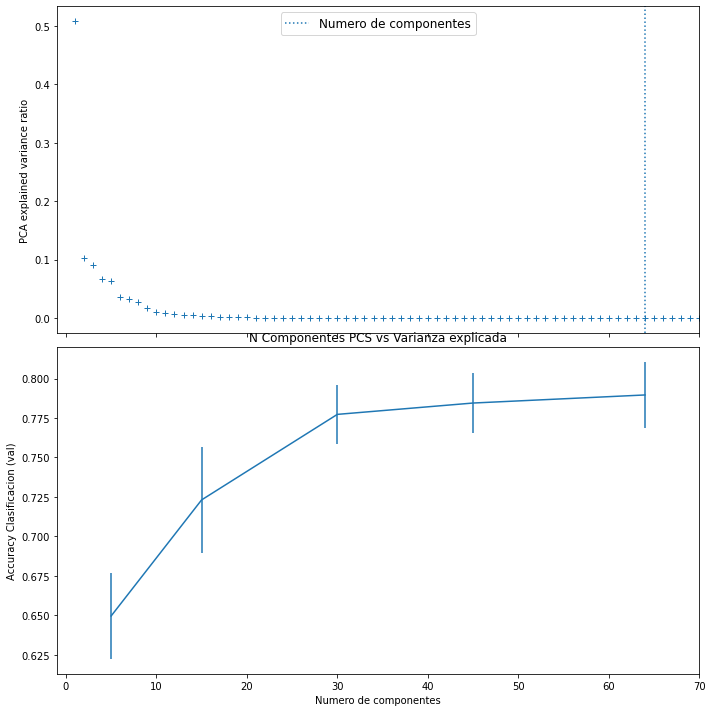

In [41]:
y = df_total['clase']
X = df_total.copy()
X = X.drop(columns=['clase'])
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

pca = PCA()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X)


fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10, 10))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explicada por el radio de la varianza')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='Numero de componentes')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Accuracy Clasificacion (val)')
ax1.set_xlabel('Numero de componentes')

plt.xlim(-1, 70)

plt.tight_layout()
plt.title("N Componentes PCS vs Varianza explicada")
plt.show()

Parece ser que con cerca de 10 componentes ya podemos explicar la mayoria de la variabilidad de los datos.